In [ ]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install pafy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/football match action video dataset/dataset.zip'

In [ ]:
# Import the required libraries.
import os
from os import path
import cv2
import pafy
# import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import moviepy.editor as mp

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Get the names of all classes/categories in dataset.
all_classes_names = os.listdir('/content/dataset')

Data preprocessing

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20

DATASET_DIR = '/content/dataset'

CLASSES_LIST = ["goal", "happy", "losses"]

In [ ]:
def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)


            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: goal
Extracting Data of Class: happy
Extracting Data of Class: losses


In [ ]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Model construction

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct a convlstm model for our goal,
     red card and tackling classification task.
    '''
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    model.summary()

    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 20, 31, 31, 4)     0         
 g3D)                                                            
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 31, 31, 4)     0         
 stributed)                                                      
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
7/7 [==============================] - 14s 491ms/step - loss: 1.1020 - accuracy: 0.2963 - val_loss: 1.0737 - val_accuracy: 0.4286
Epoch 2/50
7/7 [==============================] - 2s 304ms/step - loss: 1.0708 - accuracy: 0.4074 - val_loss: 0.9870 - val_accuracy: 0.4286
Epoch 3/50
7/7 [==============================] - 2s 311ms/step - loss: 1.0639 - accuracy: 0.4444 - val_loss: 0.9901 - val_accuracy: 0.4286
Epoch 4/50
7/7 [==============================] - 5s 812ms/step - loss: 0.9788 - accuracy: 0.5185 - val_loss: 0.9779 - val_accuracy: 0.4286
Epoch 5/50
7/7 [==============================] - 3s 414ms/step - loss: 0.8592 - accuracy: 0.5556 - val_loss: 0.8061 - val_accuracy: 0.4286
Epoch 6/50
7/7 [==============================] - 2s 288ms/step - loss: 0.6636 - accuracy: 0.6667 - val_loss: 0.9957 - val_accuracy: 0.4286
Epoch 7/50
7/7 [==============================] - 2s 295ms/step - loss: 0.5419 - accuracy: 0.7407 - val_loss: 0.5923 - val_accuracy: 0.7143
Epoch 8/50
7/7 [===

In [ ]:
# Evaluating the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 83ms/step - loss: 0.6015 - accuracy: 0.6667


In [ ]:
'''we will be saving model with date and time info for easiness sake.
'''
# Getting the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving the Model.
convlstm_model.save(model_file_name)

Plotting the accuracy and loss (training and validation )

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

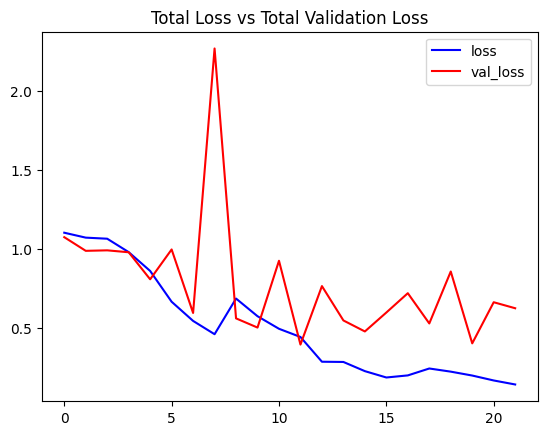

In [ ]:
# Visualizing the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

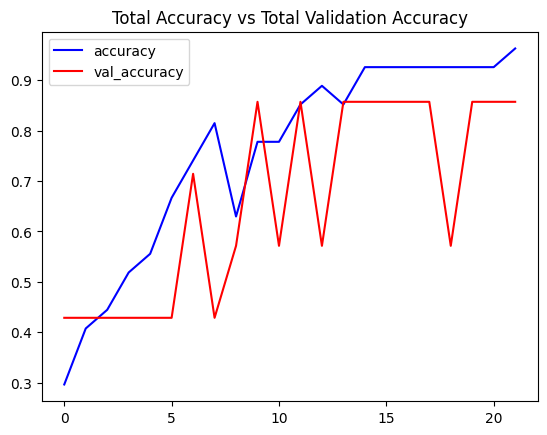

In [ ]:
# Visualizing the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Testing our model with an actual football highlights video

In [ ]:
# Getting the test Video's path .
file_path = '/content/Giroud header wins it! _ England v France _ FIFA World Cup Qatar 2022.mp4'

In [ ]:
!pip install scikit-video

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.9 MB/s eta 0:00:00


In [ ]:
reader = cv2.VideoCapture(file_path)

In [ ]:
fps_org = reader.get(cv2.CAP_PROP_FPS)

In [ ]:
frames_list = []

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

In [ ]:
dim = (IMAGE_HEIGHT , IMAGE_WIDTH)

In [ ]:
ret = True

In [ ]:
while ret:
  ret , img = reader.read()
  if not ret:
    break
  image = cv2.resize(img,dim)
  norm = image / 255
  arr = np.array(norm)
  frames_list.append(arr)

In [ ]:
reader.release()

In [ ]:
frames_list[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.01568627],
        [0.        , 0.        , 0.04705882]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.00392157],
        [0.00392157, 0.        , 0.01568627]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.01176471]],

       ...,

       [[0.01568627, 0.10980392, 0.10196078],
        [0.05098039, 0.0627451 , 0.08235294],
        [0.10196078, 0

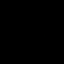

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(frames_list[2445])

In [ ]:
len(frames_list)

3193

Preprocessing the test video

In [ ]:
''' As you can see the clips we preprocessed and fed into our convlstm2D model were short clips of 20 frames each
    They were 20 frames chosen at equal intervals from clips of around 2 secs
    (in 2 seconds at 30 fps of the original video it would mean 60 frames per video clip)'''

' As you can see the clips we preprocessed and fed into our convlstm2D model were short clips of 20 frames each\n    They were 20 frames chosen at equal intervals from clips of around 2 secs\n    (in 2 seconds at 30 fps of the original video it would mean 60 frames per video clip)'

In [ ]:
#thus we are preparing clips of 60 frames each(converted to 20 frames like above)

In [ ]:
#we will be running our model on each of these clips and locating where an event happened.

In [ ]:
#a confidence threshold of 0.7 is added to locate only moments where the model is very sure an event happened

In [ ]:
frame_limit = 60

In [ ]:
tmp_lst =[]

In [ ]:
for i in range(round(len(frames_list)/frame_limit)):
  tmp_lst.append(frames_list[i*frame_limit:(i+1)*frame_limit])

In [ ]:
len(tmp_lst)

53

In [ ]:
len(tmp_lst[0])

60

In [ ]:
sequence_length = 20

In [ ]:
frame_skipper = frame_limit/sequence_length

In [ ]:
preprocessed_clips_list = []

In [ ]:
for i in range(len(tmp_lst)):
  frame_lst = []
  for k in range(len(tmp_lst[i])):
    if k%frame_skipper==0:
      frame_lst.append(tmp_lst[i][k])
  arr1 = np.array(frame_lst)
  preprocessed_clips_list.append(arr1)

In [ ]:
tmp_lst[0][i].dtype

dtype('float64')

In [ ]:
len(preprocessed_clips_list)

53

In [ ]:
preprocessed_clips_list[0].shape

(20, 64, 64, 3)

In [ ]:
predictions = []
confidence = []

In [ ]:
for i in range(len(preprocessed_clips_list)):
  predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(preprocessed_clips_list[i], axis = 0))[0]
  predicted_label = np.argmax(predicted_labels_probabilities)
  confidence.append(predicted_labels_probabilities[predicted_label])
  predictions.append(predicted_label)


1/1 [==============================] - 0s 88ms/step


In [ ]:
predicted_labels_probabilitiesww = convlstm_model.predict(np.expand_dims(preprocessed_clips_list[0], axis = 0))[0]

1/1 [==============================] - 0s 82ms/step


In [ ]:
predicted_labels_probabilitiesww

array([0.00738451, 0.09524258, 0.8973729 ], dtype=float32)

In [ ]:
predictions[0]

2

In [ ]:
confidence

[0.8973729,
 0.7166453,
 0.8010938,
 0.84900284,
 0.91613716,
 0.56969446,
 0.7894798,
 0.7675694,
 0.4270539,
 0.9336042,
 0.9375617,
 0.80144596,
 0.8730465,
 0.8374621,
 0.8250869,
 0.74406993,
 0.84754235,
 0.9392276,
 0.9024545,
 0.793385,
 0.7830226,
 0.82983804,
 0.9405504,
 0.54940677,
 0.6050728,
 0.83342934,
 0.60135376,
 0.8354258,
 0.6965363,
 0.8951968,
 0.89517635,
 0.82675266,
 0.94595885,
 0.9403839,
 0.9139506,
 0.7208565,
 0.7322618,
 0.6440274,
 0.6568991,
 0.9573855,
 0.8977184,
 0.40690845,
 0.59879833,
 0.7664899,
 0.8350221,
 0.6755231,
 0.9314116,
 0.7035518,
 0.6489806,
 0.7175968,
 0.7111528,
 0.9466912,
 0.95238596]

In [ ]:
conf_arr = np.array(confidence)

In [ ]:
#locating clips where an event is predicted with more than 0.7 confidence

In [ ]:
indices = np.where(conf_arr>0.7)[0]

In [ ]:
indices #array of clip indices where an even happened above 0.7 confidence

array([ 0,  1,  2,  3,  4,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 43,
       44, 46, 47, 49, 50, 51, 52])

In [ ]:
event_label = np.array(predictions) #creating an array of predictions

In [ ]:
event_label.shape

(53,)

In [ ]:
indices.shape

(41,)

In [ ]:
labels_of_events = np.take(event_label,indices) #creating a sorted array with predictions corresponding to an event

In [ ]:
labels_of_events.shape

(41,)

In [ ]:
#creating a dataframe with clip index and its corresponding prediction label

In [ ]:
df = pd.DataFrame(indices,columns=['event_index'])

In [ ]:
df['predictions'] = labels_of_events

In [ ]:
df

,event_index,predictions
0,0,2
1,1,2
2,2,0
3,3,0
4,4,0
5,6,1
6,7,2
7,9,0
8,10,0
9,11,0


In [ ]:
fps_org #fps of original test video

25.0

In [ ]:
'''
keywords;
index_no: index of clip where the event happened
frame_limit: 60 (no of frames of original video we clubbed together)
fps_org: fps of the original test video

Thus the time(in sec) of the event clip in the original video
based on the index no of clip would be;

moment = index_no*frame_limit/fps_org'''

In [ ]:
'''
Thus we can extract a clip using moviepy,
 starting 5 secs before the event moment and
 ending 5 secs after the event moment;
by defining the below variables:

start_time = moment - 5
end_time = moment + 5

 '''

In [ ]:
max_time = len(frames_list)/fps_org #ending time of the original test video

Video Extraction using Moviepy

In [ ]:
#creating a folder for storing 3 class folders
os.mkdir('/content/classified_moments')

In [ ]:
# creating folders for storing clips of each corresponding classes

os.mkdir('/content/classified_moments/Goal')
os.mkdir('/content/classified_moments/Happy')
os.mkdir('/content/classified_moments/Loss')

In [ ]:
df.head(8)

,event_index,predictions
0,0,2
1,1,2
2,2,0
3,3,0
4,4,0
5,6,1
6,7,2
7,9,0


In [ ]:
'''
To prevent value error;
 in case the starting time(moment -5 sec) is less than the begining of the original test video
 or
 in case the ending time(moment + 5 sec) is greater than the ending time of the original test video,
 I have written the extraction part as below
 '''

In [ ]:
for i in range(len(df['predictions'])):
  index = df['event_index'][i]
  moment = index*frame_limit/fps_org
  start_time = moment - 5
  end_time = moment + 5
  clip = mp.VideoFileClip('/content/Giroud header wins it! _ England v France _ FIFA World Cup Qatar 2022.mp4')
  if df['predictions'][i] == 0:
  # Create a cropped subclip that starts at {start_time} seconds and ends at {end_time} seconds if event is Goal
    # Create a cropped subclip after checking for out of time extractions
    if start_time < 0:
      start_time = 0
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Goal/goal{i}.mp4")
    if end_time > max_time:
      end_time = max_time
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Goal/goal{i}.mp4")
    else:
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Goal/goal{i}.mp4")
  if df['predictions'][i] == 1:
  # Create a cropped subclip that starts at {start_time} seconds and ends at {end_time} seconds if event is Happy
    if start_time < 0:
      start_time = 0
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Happy/happy{i}.mp4")
    if end_time > max_time:
      end_time = max_time
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Happy/happy{i}.mp4")
    else:
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Happy/happy{i}.mp4")
  if df['predictions'][i] == 2:
  # Create a cropped subclip that starts at {start_time} seconds and ends at {end_time} seconds if event is Loss
    if start_time < 0:
      start_time = 0
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Happy/happy{i}.mp4")
    if end_time > max_time:
      end_time = max_time
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Happy/happy{i}.mp4")
    else:
      cropped_clip = clip.subclip(start_time, end_time)
      cropped_clip.write_videofile(f"/content/classified_moments/Happy/happy{i}.mp4")

Moviepy - Building video /content/classified_moments/Happy/happy0.mp4.
MoviePy - Writing audio in happy0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy0.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy0.mp4
Moviepy - Building video /content/classified_moments/Happy/happy0.mp4.
MoviePy - Writing audio in happy0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy0.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy0.mp4
Moviepy - Building video /content/classified_moments/Happy/happy1.mp4.
MoviePy - Writing audio in happy1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy1.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy1.mp4
Moviepy - Building video /content/classified_moments/Happy/happy1.mp4.
MoviePy - Writing audio in happy1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy1.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy1.mp4
Moviepy - Building video /content/classified_moments/Goal/goal2.mp4.
MoviePy - Writing audio in goal2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal2.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal2.mp4
Moviepy - Building video /content/classified_moments/Goal/goal2.mp4.
MoviePy - Writing audio in goal2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal2.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal2.mp4
Moviepy - Building video /content/classified_moments/Goal/goal3.mp4.
MoviePy - Writing audio in goal3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal3.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal3.mp4
Moviepy - Building video /content/classified_moments/Goal/goal4.mp4.
MoviePy - Writing audio in goal4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal4.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal4.mp4
Moviepy - Building video /content/classified_moments/Happy/happy5.mp4.
MoviePy - Writing audio in happy5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy5.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy5.mp4
Moviepy - Building video /content/classified_moments/Happy/happy6.mp4.
MoviePy - Writing audio in happy6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy6.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy6.mp4
Moviepy - Building video /content/classified_moments/Goal/goal7.mp4.
MoviePy - Writing audio in goal7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal7.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal7.mp4
Moviepy - Building video /content/classified_moments/Goal/goal8.mp4.
MoviePy - Writing audio in goal8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal8.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal8.mp4
Moviepy - Building video /content/classified_moments/Goal/goal9.mp4.
MoviePy - Writing audio in goal9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal9.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal9.mp4
Moviepy - Building video /content/classified_moments/Goal/goal10.mp4.
MoviePy - Writing audio in goal10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal10.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal10.mp4
Moviepy - Building video /content/classified_moments/Goal/goal11.mp4.
MoviePy - Writing audio in goal11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal11.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal11.mp4
Moviepy - Building video /content/classified_moments/Goal/goal12.mp4.
MoviePy - Writing audio in goal12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal12.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal12.mp4
Moviepy - Building video /content/classified_moments/Goal/goal13.mp4.
MoviePy - Writing audio in goal13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal13.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal13.mp4
Moviepy - Building video /content/classified_moments/Goal/goal14.mp4.
MoviePy - Writing audio in goal14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal14.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal14.mp4
Moviepy - Building video /content/classified_moments/Goal/goal15.mp4.
MoviePy - Writing audio in goal15TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal15.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal15.mp4
Moviepy - Building video /content/classified_moments/Goal/goal16.mp4.
MoviePy - Writing audio in goal16TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal16.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal16.mp4
Moviepy - Building video /content/classified_moments/Goal/goal17.mp4.
MoviePy - Writing audio in goal17TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal17.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal17.mp4
Moviepy - Building video /content/classified_moments/Goal/goal18.mp4.
MoviePy - Writing audio in goal18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal18.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal18.mp4
Moviepy - Building video /content/classified_moments/Goal/goal19.mp4.
MoviePy - Writing audio in goal19TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal19.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal19.mp4
Moviepy - Building video /content/classified_moments/Goal/goal20.mp4.
MoviePy - Writing audio in goal20TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal20.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal20.mp4
Moviepy - Building video /content/classified_moments/Goal/goal21.mp4.
MoviePy - Writing audio in goal21TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal21.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal21.mp4
Moviepy - Building video /content/classified_moments/Goal/goal22.mp4.
MoviePy - Writing audio in goal22TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal22.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal22.mp4
Moviepy - Building video /content/classified_moments/Goal/goal23.mp4.
MoviePy - Writing audio in goal23TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal23.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal23.mp4
Moviepy - Building video /content/classified_moments/Goal/goal24.mp4.
MoviePy - Writing audio in goal24TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal24.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal24.mp4
Moviepy - Building video /content/classified_moments/Goal/goal25.mp4.
MoviePy - Writing audio in goal25TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal25.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal25.mp4
Moviepy - Building video /content/classified_moments/Goal/goal26.mp4.
MoviePy - Writing audio in goal26TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal26.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal26.mp4
Moviepy - Building video /content/classified_moments/Goal/goal27.mp4.
MoviePy - Writing audio in goal27TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal27.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal27.mp4
Moviepy - Building video /content/classified_moments/Goal/goal28.mp4.
MoviePy - Writing audio in goal28TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal28.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal28.mp4
Moviepy - Building video /content/classified_moments/Goal/goal29.mp4.
MoviePy - Writing audio in goal29TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal29.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal29.mp4
Moviepy - Building video /content/classified_moments/Goal/goal30.mp4.
MoviePy - Writing audio in goal30TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal30.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal30.mp4
Moviepy - Building video /content/classified_moments/Goal/goal31.mp4.
MoviePy - Writing audio in goal31TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal31.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal31.mp4
Moviepy - Building video /content/classified_moments/Goal/goal32.mp4.
MoviePy - Writing audio in goal32TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal32.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal32.mp4
Moviepy - Building video /content/classified_moments/Goal/goal33.mp4.
MoviePy - Writing audio in goal33TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal33.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal33.mp4
Moviepy - Building video /content/classified_moments/Goal/goal34.mp4.
MoviePy - Writing audio in goal34TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal34.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal34.mp4
Moviepy - Building video /content/classified_moments/Goal/goal35.mp4.
MoviePy - Writing audio in goal35TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Goal/goal35.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Goal/goal35.mp4
Moviepy - Building video /content/classified_moments/Happy/happy36.mp4.
MoviePy - Writing audio in happy36TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy36.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy36.mp4
Moviepy - Building video /content/classified_moments/Happy/happy37.mp4.
MoviePy - Writing audio in happy37TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy37.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy37.mp4
Moviepy - Building video /content/classified_moments/Happy/happy38.mp4.
MoviePy - Writing audio in happy38TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy38.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy38.mp4
Moviepy - Building video /content/classified_moments/Happy/happy39.mp4.
MoviePy - Writing audio in happy39TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy39.mp4



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy39.mp4
Moviepy - Building video /content/classified_moments/Happy/happy40.mp4.
MoviePy - Writing audio in happy40TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/classified_moments/Happy/happy40.mp4



t:  97%|█████████▋| 194/199 [00:04<00:00, 56.24it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/Giroud header wins it! _ England v France _ FIFA World Cup Qatar 2022.mp4, 2764800 bytes wanted but 0 bytes read,at frame 3193/3194, at time 127.72/127.73 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/classified_moments/Happy/happy40.mp4


In [ ]:
/content/classified_moments

7

In [ ]:
!zip -r classified_moments.zip classified_moments/

  adding: classified_moments/ (stored 0%)
  adding: classified_moments/Happy/ (stored 0%)
  adding: classified_moments/Happy/happy0.mp4 (deflated 1%)
  adding: classified_moments/Happy/happy40.mp4 (deflated 28%)
  adding: classified_moments/Happy/happy1.mp4 (deflated 0%)
  adding: classified_moments/Happy/happy5.mp4 (deflated 0%)
  adding: classified_moments/Happy/happy36.mp4 (deflated 0%)
  adding: classified_moments/Happy/happy39.mp4 (deflated 7%)
  adding: classified_moments/Happy/happy38.mp4 (deflated 3%)
  adding: classified_moments/Happy/happy37.mp4 (deflated 2%)
  adding: classified_moments/Happy/happy6.mp4 (deflated 0%)
  adding: classified_moments/Goal/ (stored 0%)
  adding: classified_moments/Goal/goal23.mp4 (deflated 0%)
  adding: classified_moments/Goal/goal15.mp4 (deflated 0%)
  adding: classified_moments/Goal/goal2.mp4 (deflated 0%)
  adding: classified_moments/Goal/goal9.mp4 (deflated 0%)
  adding: classified_moments/Goal/goal25.mp4 (deflated 0%)
  adding: classified_mom

41